In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

np.random.seed(0)

/Users/kp9/anaconda3/envs/orig/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.2.2 anndata==0.6.4 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.0 


Hello and welcome to a brief simulation demonstration of BBKNN! We're going to construct a bunch of objects with a known ground truth cell population composition and take a look at how BBKNN handles them.

Let's begin by defining signatures for a few independently simulated cell types by sampling 1,000 random numbers from `U(0,1)` for each, and then raising them to the tenth power. This creates a right-skewed distribution centered around 0, with a handful of "signature genes" with high expression values.

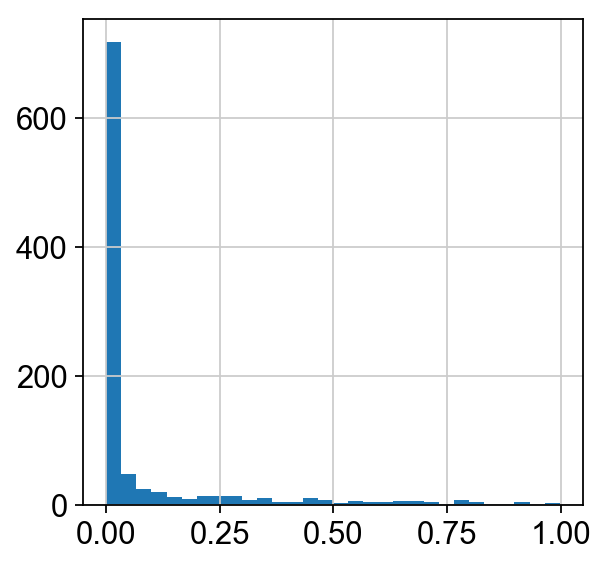

In [2]:
celltypeA = np.random.random((1,1000))**10
celltypeB = np.random.random((1,1000))**10
celltypeC = np.random.random((1,1000))**10

plt.hist(np.transpose(celltypeA),bins=30)
plt.show()

Let's prepare three populations featuring 200 of each type of cell. The signatures we created are slightly noised up by adding `N(0,0.1)` to add some cell variation.

In [3]:
expr_template = np.vstack((np.tile(celltypeA,(200,1)),np.tile(celltypeB,(200,1)),np.tile(celltypeC,(200,1))))
exprs0 = expr_template + np.random.normal(size=(600,1000),scale=0.1)
exprs1 = expr_template + np.random.normal(size=(600,1000),scale=0.1)
exprs2 = expr_template + np.random.normal(size=(600,1000),scale=0.1)

Simulate a batch effect by multiplying each gene's expression by a batch-specific coefficient drawn from `N(1,0.5)`.

In [4]:
batch0 = np.random.normal(size=(1,1000),loc=1,scale=0.5)
batch1 = np.random.normal(size=(1,1000),loc=1,scale=0.5)
batch2 = np.random.normal(size=(1,1000),loc=1,scale=0.5)

exprs0 *= batch0
exprs1 *= batch1
exprs2 *= batch2

Create an AnnData object with the data, adding metadata identifying each cell's original cell type and batch.

In [5]:
adata = anndata.AnnData(X=np.vstack((exprs0,exprs1,exprs2)))
adata.obs['celltype'] = np.tile(np.concatenate((np.repeat('A',200),np.repeat('B',200),np.repeat('C',200))),3)
adata.obs['batch'] = [str(i) for i in np.repeat(np.arange(3),600)]

Identify the standard neighbourhood graph and visualise the cell types and batches in UMAP space. Unsurprisingly, everything is very heavily split.

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:03.51) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:03.52) --> added
    'X_umap', UMAP coordinates (adata.obsm)
... storing 'celltype' as categorical
... storing 'batch' as categorical


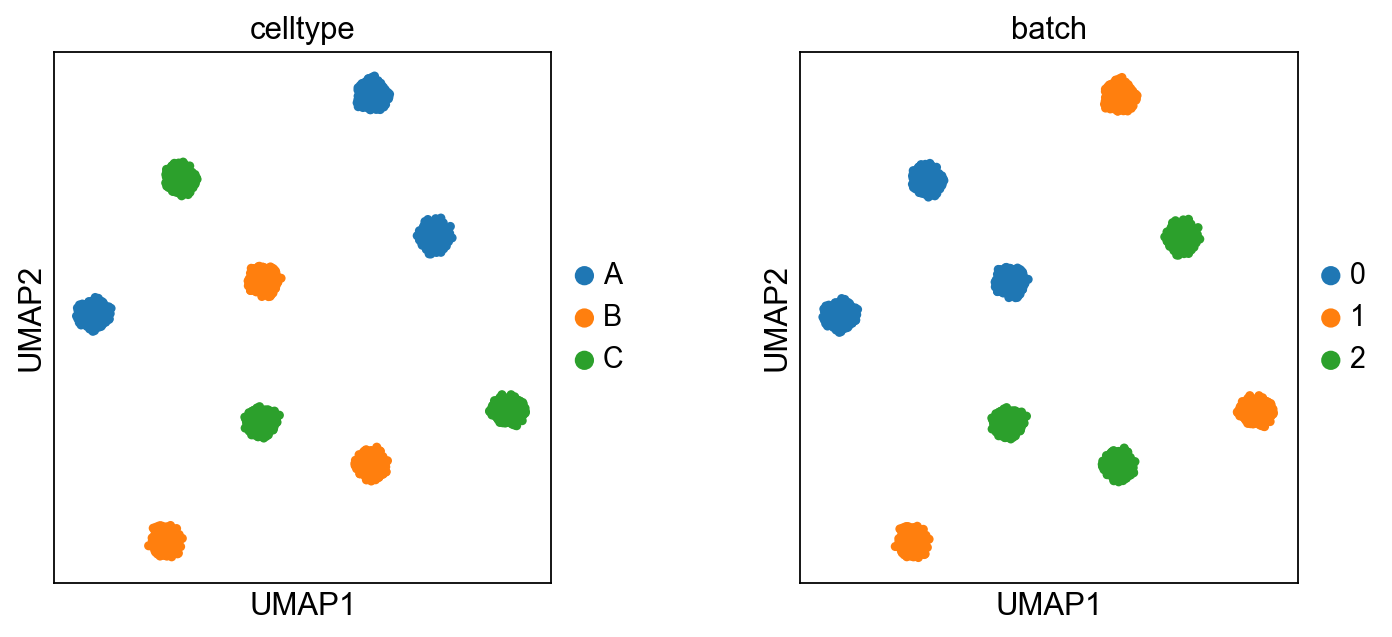

In [6]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['celltype','batch'])

Replace the neighbourhood graph inference with BBKNN. Observe as the cell types become reconnected.

computing batch balanced neighbors
    finished (0:00:02.84) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.95) --> added
    'X_umap', UMAP coordinates (adata.obsm)


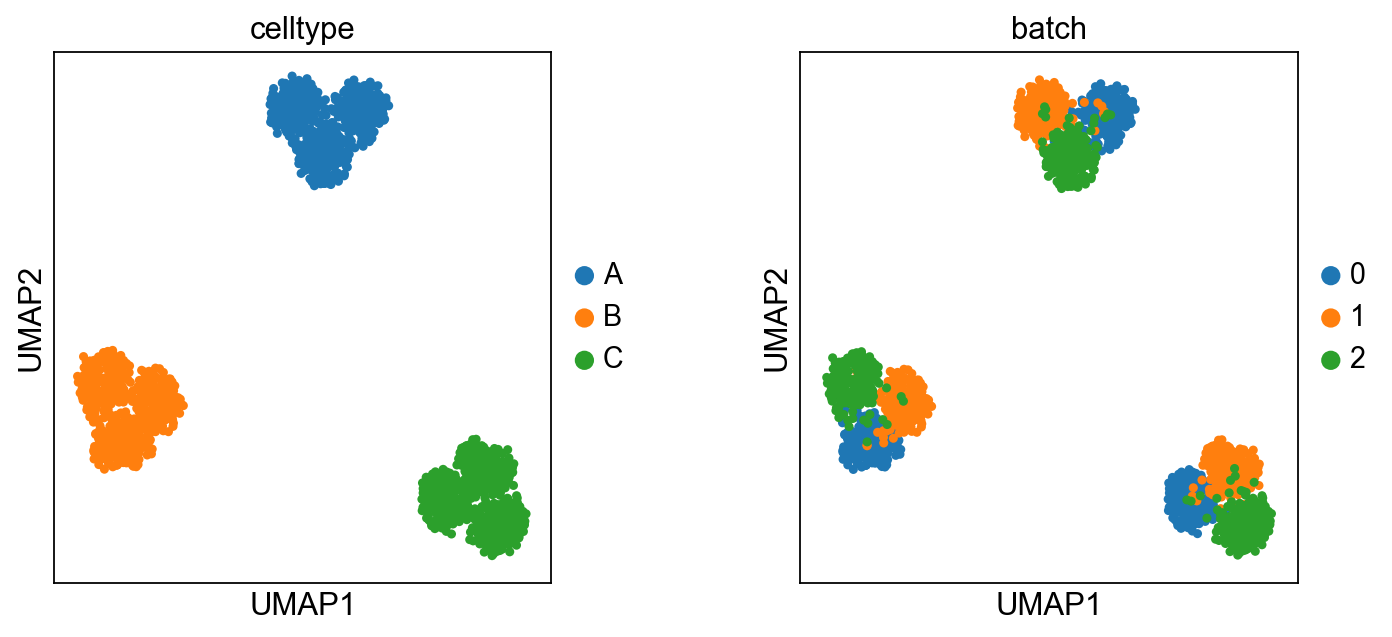

In [7]:
bbknn.bbknn(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['celltype','batch'])

Since we're simulating, let's inspect the influence of trimming on the data in the case of independent cell populations. Instead of using three populations with three cell types, let's keep one of our original three-cell-type populations and add a new sample which only has two of those populations present.

In [8]:
exprs3 = np.vstack((np.tile(celltypeA,(300,1)),np.tile(celltypeB,(300,1)))) + np.random.normal(size=(600,1000),scale=0.1)
batch3 = np.random.normal(size=(1,1000),loc=1,scale=0.5)
exprs3 *= batch3

adata = anndata.AnnData(X=np.vstack((exprs0,exprs3)))
adata.obs['celltype'] = np.concatenate((np.repeat('A',200),np.repeat('B',200),np.repeat('C',200),np.repeat('A',300),np.repeat('B',300)))
adata.obs['batch'] = [str(i) for i in np.repeat(np.arange(2),600)]

BBKNN successfully reconnects cells A and B, but erroneously places C near the A cluster.

computing batch balanced neighbors
    finished (0:00:00.11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.03) --> added
    'X_umap', UMAP coordinates (adata.obsm)
... storing 'celltype' as categorical
... storing 'batch' as categorical


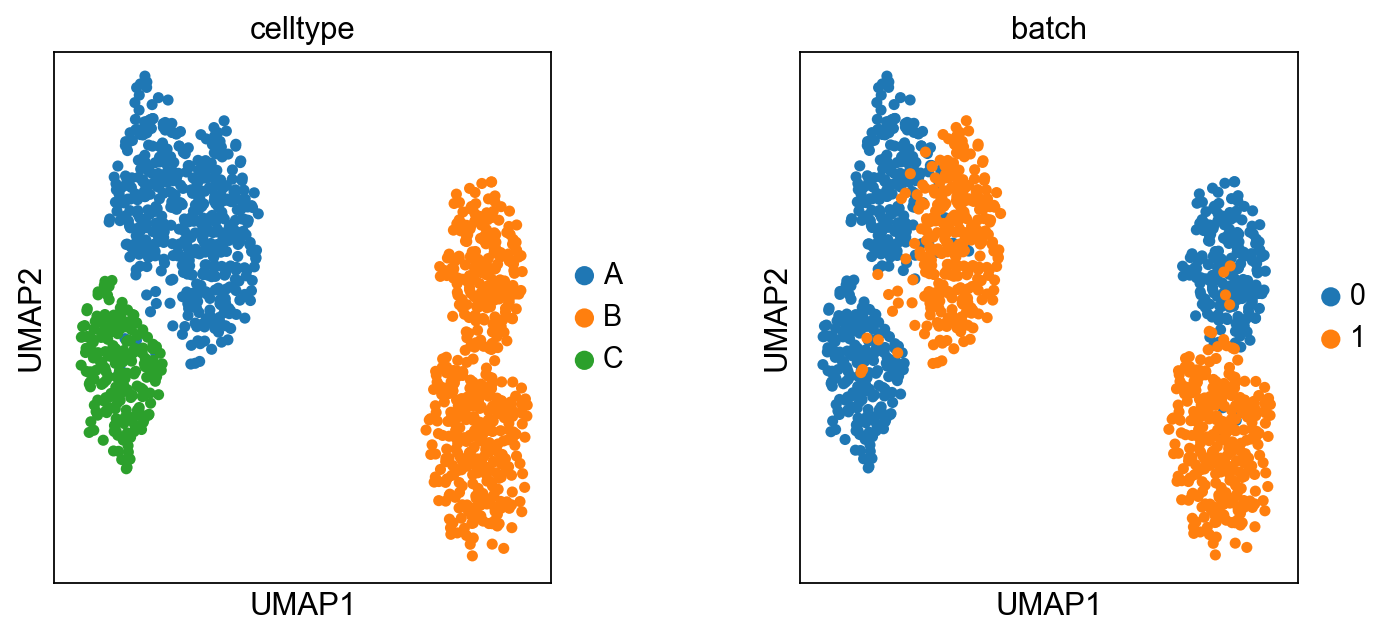

In [9]:
sc.tl.pca(adata)
bbknn.bbknn(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['celltype','batch'])

We can mitigate this effect by trimming the graph to only feature the best connectivities for each of the cells. Once we do that, the C cells are autonomous.

computing batch balanced neighbors
    finished (0:00:00.12) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:00.76) --> added
    'X_umap', UMAP coordinates (adata.obsm)


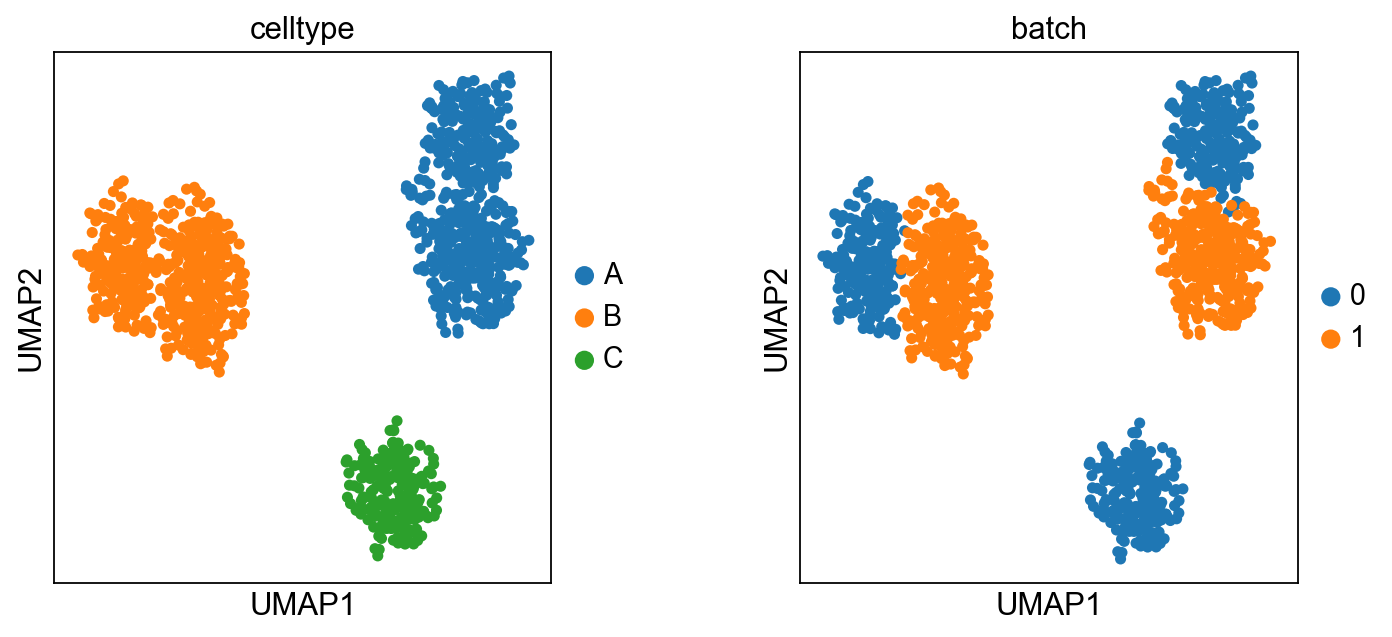

In [10]:
bbknn.bbknn(adata, trim=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['celltype','batch'])